# 주제: NBA선수 연봉과 가치 평가

========================================================================================================================

## 목적 설정 및 프로세스

* 올해 선수들의 경기 결과 데이터(X)와 다음 시즌 선수들의 연봉 데이터(y)를 인과관계로 둔다.

* 연봉 예측은 사실상 불가능하다.(관련된 요소들이 많기 때문에). 따라서 연봉 순위 30위권까지 예측해보겠다.

* 평가는 올해(15~16)의 데이터를 바탕으로 다음 시즌(16~17)을 맞춰보자.(test set)

* 데이터는 6년치(07, 08, 09, 10, 11, 12, 13, 14 X데이터)의 결과 데이터로 만든다. 회귀분석의 방법으로 예측(train set)

* 데이터 수집 - 데이터 탐구 - 예측 모델링 - 모델 검증 - 결과 시각화

* 모델 검증 과정
    1. 독립변수 12개로 기본적인 모델링을 하여 예측

    2. Feature로 PTS(평균 득점력)만 놓고 직관적 판단의 성능으로 예측

    3. 내가 생각하는 feature로만 선택하여 모델링 후 예측
    
========================================================================================================================

## 데이터 전처리

#### 1번 X값으로 사용할 항목_12개
* AGE: 선수들 나이
* W_PCT: 승률
* MIN: 게임 뛴 시간(모든 시간/뛴 모든 경기수)
* FG_PCT: 2점슛(필드골) 성공률
* FG3_PCT: 3점슛 성공률
* FT_PCT: 1점슛(자유투) 성공률
* REB: 리바운드
* AST: assists
* STL: steals
* BLK: blocks
* TOV: turn over
* PTS: 평균 득점력(모든 득점력/뛴 모든 경기수)(Points Per Game)

#### 2번 X값으로 사용할 항목_1개
* PTS: 평균 득점력(모든 득점력/뛴 모든 경기수)

#### 3번 X값으로 사용할 항목_7개
* AGE: 선수들 나이
* W_PCT: 승률
* FG_PCT: 2점슛(필드골) 성공률
* FG3_PCT: 3점슛 성공률
* REB: 리바운드
* AST: assists
* PTS: 평균 득점력(모든 득점력/뛴 모든 경기수)

#### y값으로 사용할 항목
* Salary(연봉)

In [3]:
df_all = pd.read_csv("df_all")

In [4]:
len(df_all)

2711

In [5]:
# 불필요한 column들을 제거하자.
df_all.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD',
       'PTS', 'PLUS_MINUS', 'DD2', 'TD3', 'CFID', 'CFPARAMS', 'Salary'],
      dtype='object')

In [6]:
df_all.drop(['Unnamed: 0', 'Unnamed: 0.1', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GP', 'W', 'L', 'FGM',
       'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'BLKA', 'PF', 'PFD', 'OREB', 'DREB',
       'PLUS_MINUS', 'DD2', 'TD3', 'CFID', 'CFPARAMS'], axis=1, inplace=True)

In [7]:
#Salary 데이터 형태가 str이라서 numpy.int로 바꾸어야 함. 하지만 데이터 수집 과정에서 이미 변환
# df_all["Salary"] = df_all["Salary"].apply(lambda x: np.int(x.replace(",", "")))   
type(df_all["Salary"][0])

numpy.int64

In [8]:
from sklearn.preprocessing import StandardScaler   #스케일링 해야 합니다.
X = df_all.ix[:, :-1]
scaler = StandardScaler(with_mean=False)           #클래스 객체 생성
X_scaled = scaler.fit_transform(X)                 #모형 계수 추정 및 자료 처리 동시 수행

dfX0 = pd.DataFrame(X_scaled, columns=X.columns)   #상수항을 만들어야 합니다.
dfX = sm.add_constant(dfX0)
dfy = df_all["Salary"]
df_all = pd.concat([dfX, dfy], axis=1)
df_all.head(3)

,const,AGE,W_PCT,MIN,FG_PCT,FG3_PCT,FT_PCT,REB,AST,TOV,STL,BLK,PTS,Salary
0,1,5.563225,4.11905,1.261558,5.529858,1.899278,5.380026,0.42647,0.878832,1.12527,0.686369,0.203196,0.879138,1045560
1,1,5.563225,2.19955,1.070734,6.761691,0.000000,3.553203,1.08556,0.361872,1.12527,0.686369,0.609588,0.726980,711517
2,1,5.563225,2.60212,1.643205,5.369185,1.185610,4.971973,0.38770,1.033921,1.25030,1.143949,0.000000,0.710073,2071680


========================================================================================================================

## 데이터 분석(통계를 통한 탐구)

### ANOVA 분석과 OLS 회귀분석을 통해 특성을 살펴보자.

#### ANOVA Test (분산 분석)
* 변동(분산)을 조각내어 유의차를 발견하는 일이다.

* SS는 Sum of Squares이다. 약간의 조정을 해서 각 인자에 대한 자유도를 고려해 주는 일을 하면 MS(Mean Square)가 된다.
 * 자유도는 가계지출 항목에 가중치를 주는 것과 유사한 것이다.

* Error는 분석 중인 데이터 속에서 명확하게 설명되지 않은 변동
 * 잡비라고 생각하면 된다. 정형화 되지도 않고 쉽게 정의하기 어려운 부분의 지출들

* F-ratio는 MS값을 "error"값으로 나누어준 값이다.
 * 일반적으로 F-ratio값이 크면 그 인자는 좀 더 중요하다는 것을 나타낸다.
 * 가계지출 항목에서 이런 인자들은 가계지출 항목에서 좀 더 중요한 항목이 될 것이다.
 * 왜 분산이 크면 중요한가? 집단 내 차이에 대한 집단 간 차이의 비율
 * F값이 클수록 집단 내의 차이는 적고 연구자의 처치에 의한 변화인 집단 간의 차이가 크다는 것을 의미

In [9]:
model = sm.OLS.from_formula("Salary ~ AGE + W_PCT + MIN + FG_PCT + FG3_PCT + FT_PCT + REB + AST + STL + BLK + TOV + PTS", data=df_all)
result = model.fit()     #모형 계수 추정, 트레이닝(training)
table = sm.stats.anova_lm(result)
table.sort_values("F", ascending=False)

,df,sum_sq,mean_sq,F,PR(>F)
MIN,1.0,2.599276e+16,2.599276e+16,2469.728988,0.000000e+00
PTS,1.0,4.191530e+15,4.191530e+15,398.262518,9.248158e-83
AGE,1.0,3.856979e+15,3.856979e+15,366.474886,1.065636e-76
TOV,1.0,1.916048e+15,1.916048e+15,182.055274,3.368992e-40
REB,1.0,1.406441e+15,1.406441e+15,133.634434,3.339420e-30
AST,1.0,1.187654e+15,1.187654e+15,112.846218,7.501450e-26
W_PCT,1.0,9.536242e+14,9.536242e+14,90.609591,3.744344e-21
FG3_PCT,1.0,4.267831e+14,4.267831e+14,40.551234,2.243655e-10
FG_PCT,1.0,3.964773e+14,3.964773e+14,37.671705,9.601506e-10
FT_PCT,1.0,1.601697e+14,1.601697e+14,15.218692,9.808984e-05


* OLS 회귀분석 결과표 출력

In [10]:
model = sm.OLS(df_all.ix[:, -1], df_all.ix[:, :-1])   # 회귀 분석 
result = model.fit()
print(result.summary())                               # 결과 출력

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     321.9
Date:                Wed, 03 Aug 2016   Prob (F-statistic):               0.00
Time:                        15:11:46   Log-Likelihood:                -44485.
No. Observations:                2711   AIC:                         8.900e+04
Df Residuals:                    2698   BIC:                         8.907e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -5.722e+06   6.73e+05     -8.508      0.0

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


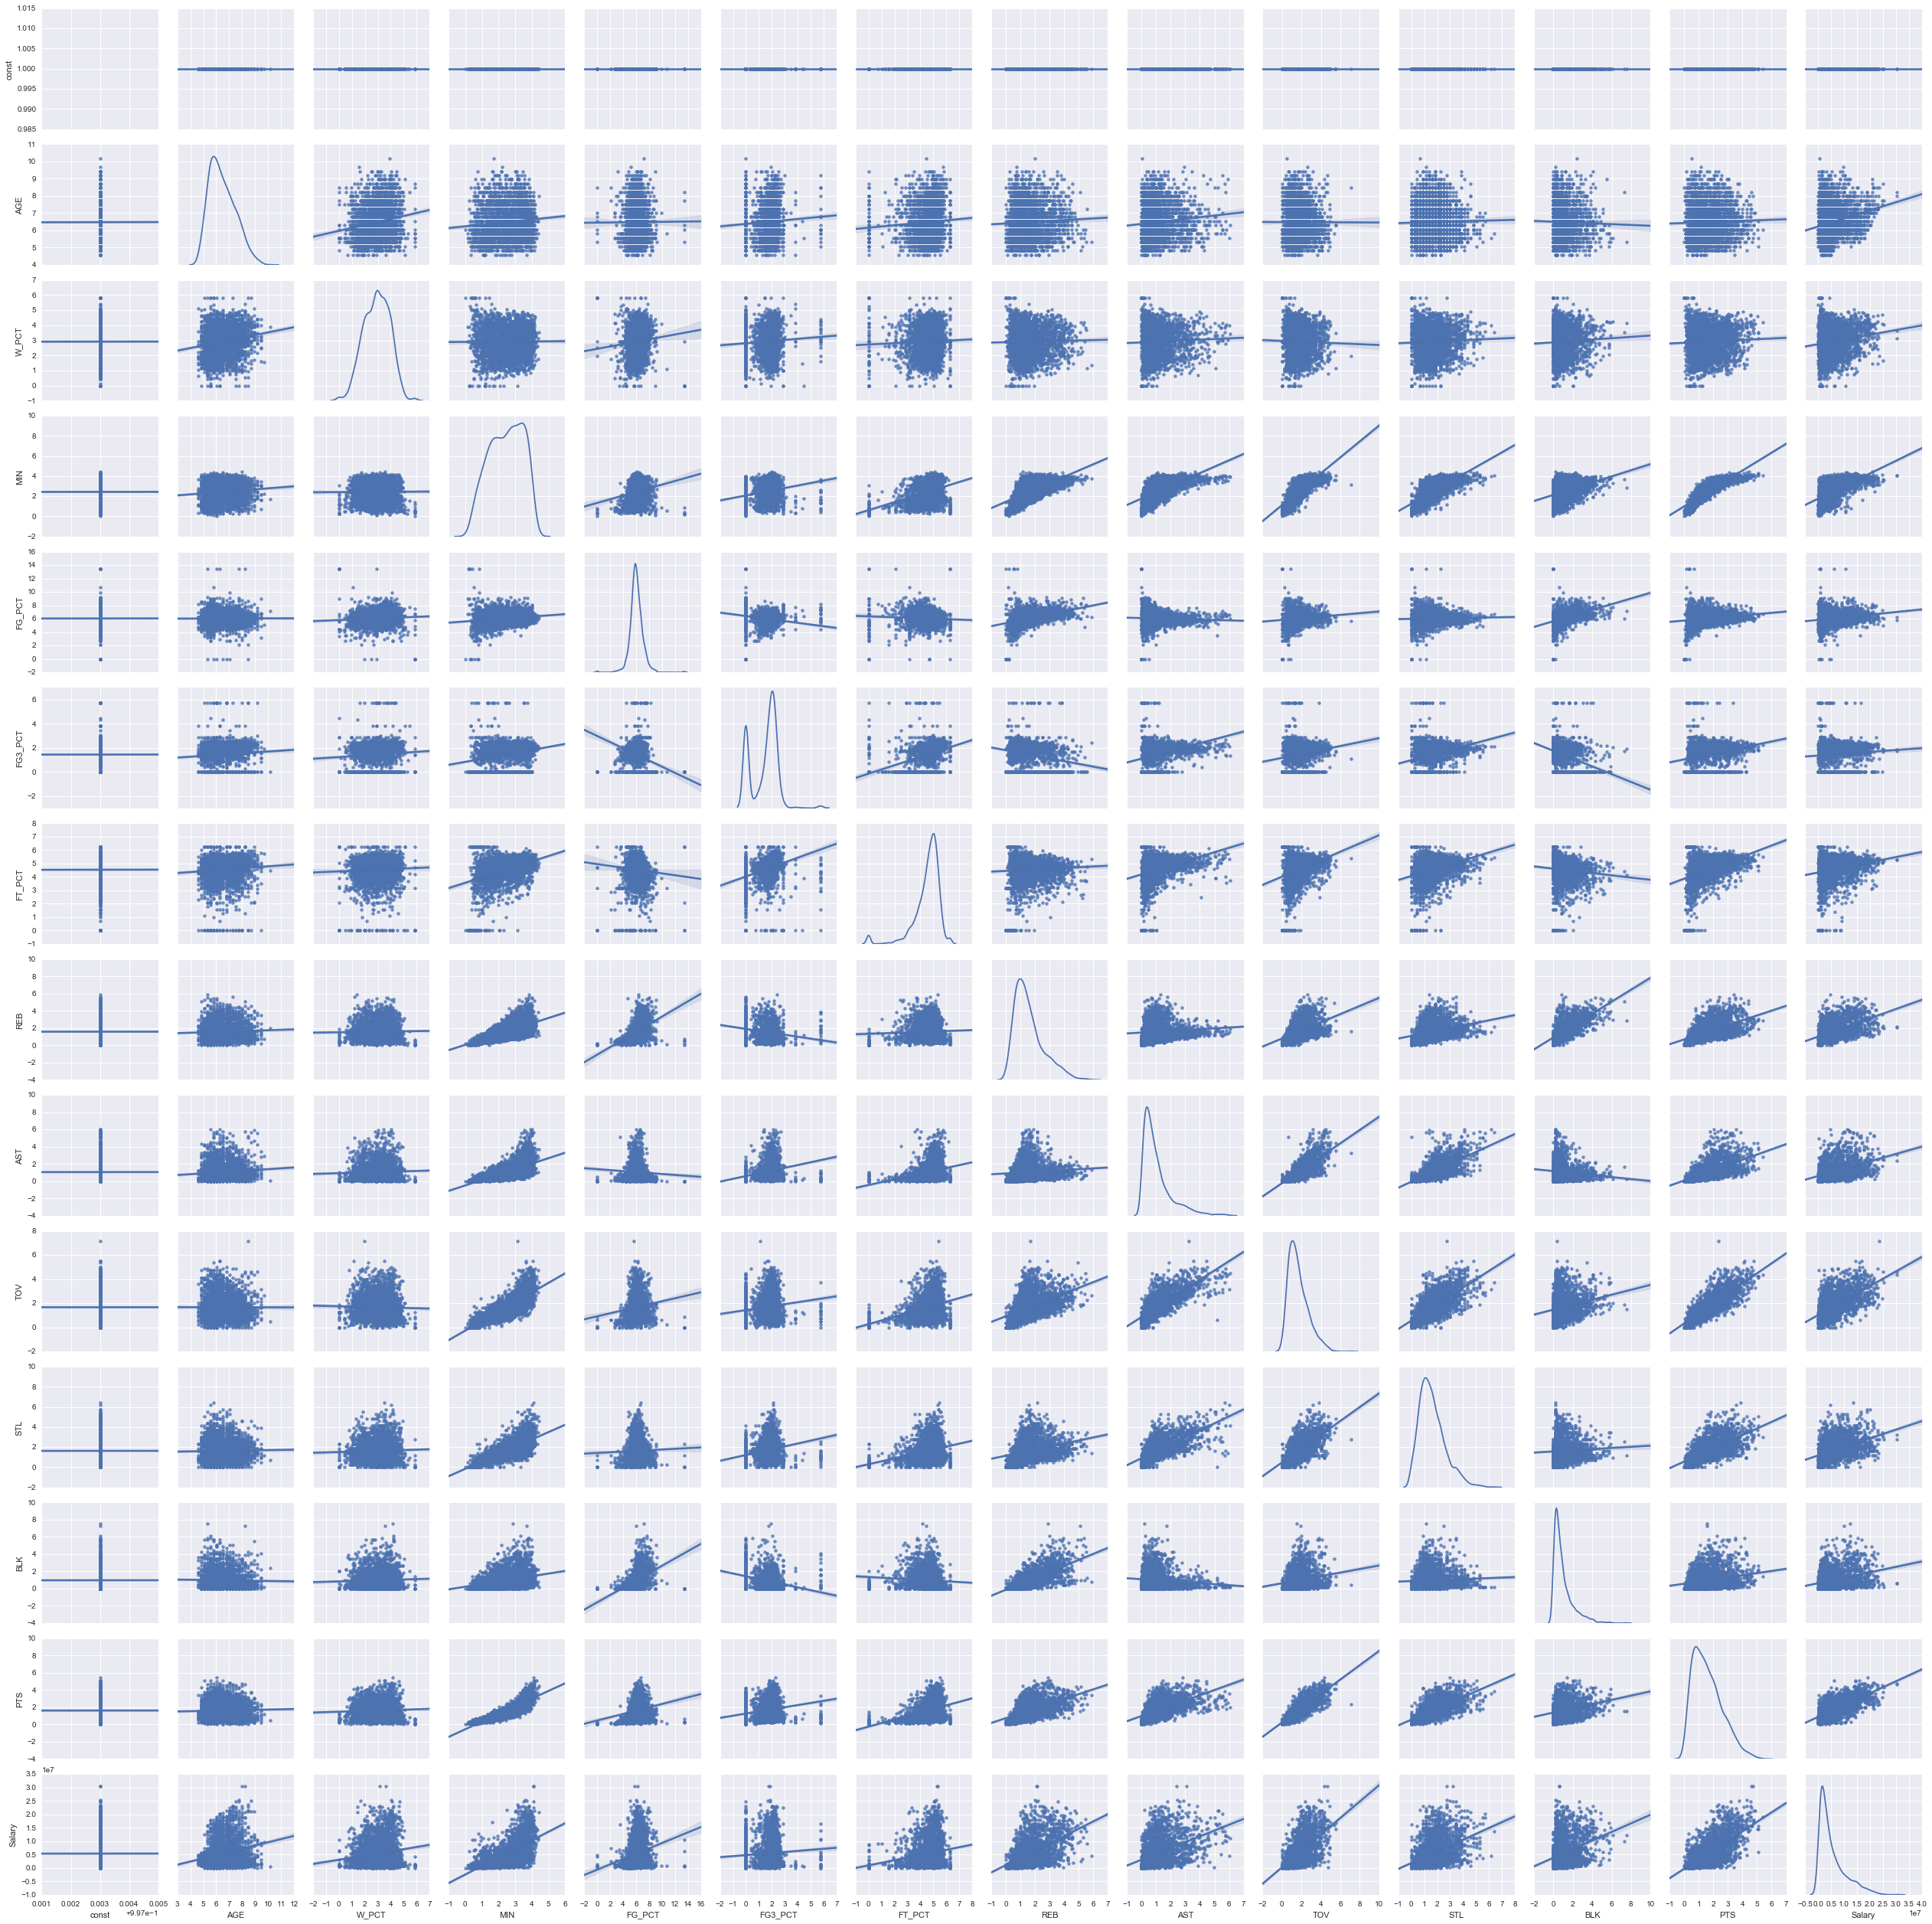

In [11]:
# 각 데이터들간의 상관관계를 살펴볼 수 있다.
sns.pairplot(df_all, diag_kind="kde", kind="reg")
plt.show()

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


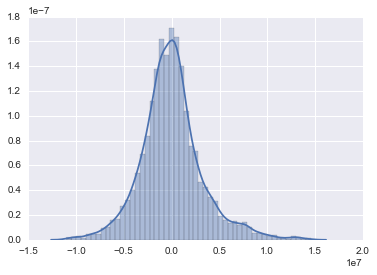

In [12]:
#오차의 분산을 나타내는 RSS(residual sum of squares)
#resid가 오차. 오차가 표준정규분포를 이루고 있는 것을 볼 수 있다.
sns.distplot(result.resid)   
plt.show();                  

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


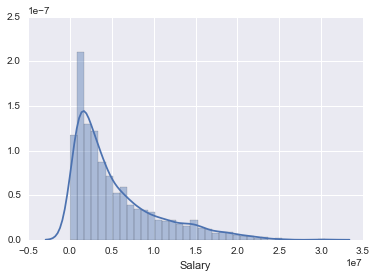

In [13]:
sns.distplot(df_all.Salary);   #아웃라이어가 거의 없어서 빼도 그만 안 빼도 그만이다.

#### OLS 회귀분석 결과
* 3점슛성공률, 2점슛 성공률, TOV의 p-value값이 너무 높게 나왔다.

* 이 독립변수들이 PTS와 독립이 아니라 상호상관관계가 강하기 때문에 다중공선성이 생겼다고 본다.

* 독립 변수가 서로 의존하게 되면 이른바 과최적화(over-fitting) 문제가 발생하여 회귀 결과의 안정성을 해치게 된다.

* 이를 방지하는 방법들은 다음과 같다.
 * 변수 선택법으로 의존적인 변수 삭제
 * PCA(principal component analysis) 방법으로 의존적인 성분 삭제
 * regularized 방법 사용
 
* 변수 제거법을 선택하겠다.

#### 과최적화란? 모형을 특정 샘플 데이터에 대해 과도하게 최적화하는 것을 과최적화(overfitting)이라고 한다.

과최적화는 
* 독립 변수 데이터 갯수에 비해 모형 모수의 수가 과도하게 크거나 
* 독립 변수 데이터가 서로 독립이 아닌 경우에 발생한다.

이러한 상황에서는 같은 조건에 대해 답이 복수개 존재할 수 있기 때문이다. 

과최적화가 문제가 되는 이유는 다음과 같다.

* 샘플이 조금만 변화해도 fitting 결과가 크게 달라지며
* 트레이닝에 사용되지 않은 새로운 독립 변수 값을 입력하면 오차가 커진다. (cross-validation 오차)

========================================================================================================================
## 예측 모델 검증 작업

### 3가지로 나누어서 평가. 모든 feature 사용한 모델, PTS만 남긴 모델, 내가 뽑은 feature로 만든 모델

* 먼저 첫 번째 모델 검증부터 시작하자

In [21]:
import requests
from bs4 import BeautifulSoup

def nba_salary_player(year):   #연봉 데이터만 수집하는 함수

    player_list = []
    
    for i in range(1, 12):
        url = "http://espn.go.com/nba/salaries/_/year/{year}/page/{i}/seasontype/4".format(year=year+1, i=i)
        response = requests.get(url)
        dom = BeautifulSoup(response.content, "html.parser")
        ranks = dom.select("tr.oddrow")                               #한 페이지에 홀수줄, 짝수줄 20개씩 나누어져 있어서 따로 가져와서
        for rank in ranks[0:20]:                                      #for문을 돌면서 name과 salary등 필요한 정보만 빈리스트에 추가
            name = str(rank.select_one("a")).split("</a>")[0].split(">")[1]
            salary = str(rank).split("</td></tr>")[0].split(">$")[1]
            player_list.append((name, salary))
        ranks = dom.select("tr.evenrow")
        for rank in ranks[0:20]:
            name = str(rank.select_one("a")).split("</a>")[0].split(">")[1]
            salary = str(rank).split("</td></tr>")[0].split(">$")[1]
            player_list.append((name, salary))    
    return player_list

In [22]:
#test set 만들기(2015년 경기기록+2016년 연봉)
bin_list = nba_salary_player(2016)
salary_2016_df = pd.DataFrame(bin_list)   #2016년도의 연봉 데이터. 즉, test_result_2015_df로
salary_2016_df.rename(columns={0: "PLAYER_NAME", 1: "Salary"}, inplace=True)
player_2015_df = pd.read_csv("./2015_nba_player_data_set.csv")   #2015년도의 선수 결과 데이터로 test_train_2015_df로
player_salary_2015_df = player_2015_df.merge(salary_2016_df, on="PLAYER_NAME")

In [23]:
len(player_salary_2015_df), len(salary_2016_df), len(player_2015_df)   # 숫자를 맞춰야 하므로 player_salary_2015_df 이것을 사용하겠다.

(330, 400, 492)

In [24]:
#Salary column type을 numpy.int로 변경
player_salary_2015_df["Salary"] = player_salary_2015_df["Salary"].apply(lambda x: np.int(x.replace(",", "")))

In [25]:
#test_result 만들기
test_result_2016_df = player_salary_2015_df[["PLAYER_NAME", "Salary"]]
test_result_2016_df.head(2)

,PLAYER_NAME,Salary
0,Aaron Gordon,4351320
1,Aaron Harrison,874636


In [26]:
#predict할 test set 만들기
test_predict_2015_df_1 = player_salary_2015_df.drop(['Unnamed: 0', 'PLAYER_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GP', 'W', 'L', 'FGM',
       'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'BLKA', 'PF', 'PFD', 'OREB', 'DREB',
       'PLUS_MINUS', 'DD2', 'TD3', 'CFID', 'CFPARAMS'], axis=1)
test_predict_2015_df_1.head()

,PLAYER_NAME,AGE,W_PCT,MIN,FG_PCT,FG3_PCT,FT_PCT,REB,AST,TOV,STL,BLK,PTS,Salary
0,Aaron Gordon,20.0,0.410,23.9,0.473,0.296,0.668,6.5,1.6,0.8,0.8,0.7,9.2,4351320
1,Aaron Harrison,21.0,0.714,4.4,0.263,0.300,0.417,0.7,0.1,0.2,0.3,0.0,0.9,874636
2,Adreian Payne,25.0,0.346,9.3,0.366,0.281,0.654,2.1,0.6,0.7,0.3,0.2,2.5,2022240
3,Al Horford,30.0,0.585,32.1,0.505,0.344,0.798,7.3,3.2,1.3,0.8,1.5,15.2,26540100
4,Al Jefferson,31.0,0.702,23.3,0.485,0.000,0.649,6.4,1.5,0.7,0.6,0.9,12.0,10314532


* test_train_2015_df_1를 predict 해보자

In [27]:
# predict 할 것이기 때문에 scale과 상수항 만드는 작업을 통일한다.
train_1 = test_predict_2015_df_1.ix[:, 1:-1]
scaler = StandardScaler(with_mean=False)
X_scaled_1 = scaler.fit_transform(train_1)   #여기서 numpy.ndarray 형태로 깨져버렸구나
dfy_test = test_predict_2015_df_1["Salary"]

dfX0_1 = pd.DataFrame(X_scaled_1, columns=train_1.columns)
dfX_11 = sm.add_constant(dfX0_1)
test_predict_2015_df_11 = pd.concat([dfX_11, dfy_test], axis=1)   #결국에는 다시 pandas.DF형태로 왔는데...
test_predict_2015_df_1 = pd.concat([test_predict_2015_df_1["PLAYER_NAME"], test_predict_2015_df_11], axis=1)
test_predict_2015_df_1.head()

,PLAYER_NAME,const,AGE,W_PCT,MIN,FG_PCT,FG3_PCT,FT_PCT,REB,AST,TOV,STL,BLK,PTS,Salary
0,Aaron Gordon,1,4.650360,2.270248,2.771407,5.936671,1.998684,4.219631,2.781462,0.865926,1.020026,1.803026,1.580989,1.689939,4351320
1,Aaron Harrison,1,4.882878,3.953554,0.510217,3.300940,2.025693,2.634111,0.299542,0.054120,0.255006,0.676135,0.000000,0.165320,874636
2,Adreian Payne,1,5.812950,1.915868,1.078414,4.593703,1.897399,4.131195,0.898626,0.324722,0.892523,0.676135,0.451711,0.459223,2022240
3,Al Horford,1,6.975540,3.239256,3.722266,6.338306,2.322795,5.040816,3.123795,1.731851,1.657542,1.803026,3.387834,2.792074,26540100
4,Al Jefferson,1,7.208058,3.887107,2.701832,6.087284,0.000000,4.099611,2.738670,0.811805,0.892523,1.352270,2.032700,2.204269,10314532


In [28]:
# 추정값 확인
model_OLS_1 = sm.OLS(dfy, dfX) 
result_OLS_1 = model_OLS_1.fit()
prediction1 = result_OLS_1.predict(test_predict_2015_df_1.ix[:, 1:-1])   #predict: 주어진 x값에 대해 y 예측
pred_y1 = pd.DataFrame(prediction1, columns=["Salary_pred"])
first_result = pd.concat([test_predict_2015_df_1["PLAYER_NAME"], pred_y1], axis=1)
first_result.head(2)

,PLAYER_NAME,Salary_pred
0,Aaron Gordon,4.471955e+06
1,Aaron Harrison,-2.537686e+05


In [29]:
test_result_2016_df.sort_values("Salary", ascending=False).head(10)  #연봉 상위 10위는 3명 맞췄다.

,PLAYER_NAME,Salary
3,Al Horford,26540100
215,Mike Conley,26540100
80,Dirk Nowitzki,25000000
43,Carmelo Anthony,24559380
61,Damian Lillard,24328425
47,Chris Bosh,23741060
86,Dwyane Wade,23200000
84,Dwight Howard,23180275
49,Chris Paul,22868827
44,Chandler Parsons,22116750


In [30]:
first_result.sort_values("Salary_pred", ascending=False).head(10)

,PLAYER_NAME,Salary_pred
278,Stephen Curry,1.950289e+07
68,DeMarcus Cousins,1.939948e+07
265,Russell Westbrook,1.805109e+07
242,Pau Gasol,1.635479e+07
18,Anthony Davis,1.597989e+07
43,Carmelo Anthony,1.536783e+07
27,Blake Griffin,1.528728e+07
61,Damian Lillard,1.510197e+07
243,Paul George,1.425472e+07
49,Chris Paul,1.399224e+07


In [31]:
#30명 중 19명 맞음
result_10 = test_result_2016_df.sort_values("Salary", ascending=False).head(10)["PLAYER_NAME"]   
predict_10 = first_result.sort_values("Salary_pred", ascending=False).head(10)["PLAYER_NAME"]
tmp1 = result_10.sort_values("index")
tmp2 = predict_10.sort_values("index")

for i in range(len(tmp1)):
    for j in range(len(tmp2)):
        if tmp1.values[i] == tmp2.values[j]:
            print(tmp1.values[i])

Carmelo Anthony
Chris Paul
Damian Lillard


In [32]:
#30명 중 18명 맞음
result_30 = test_result_2016_df.sort_values("Salary", ascending=False).head(30)["PLAYER_NAME"]   
predict_30 = first_result.sort_values("Salary_pred", ascending=False).head(30)["PLAYER_NAME"]
tmp1 = result_30.sort_values("index")
tmp2 = predict_30.sort_values("index")

for i in range(len(tmp1)):
    for j in range(len(tmp2)):
        if tmp1.values[i] == tmp2.values[j]:
            print(tmp1.values[i])

Anthony Davis
Blake Griffin
Brook Lopez
Carmelo Anthony
Chris Bosh
Chris Paul
Damian Lillard
Dirk Nowitzki
Dwight Howard
Dwyane Wade
Jimmy Butler
Kawhi Leonard
Kevin Love
LaMarcus Aldridge
Marc Gasol
Paul George
Paul Millsap
Russell Westbrook


In [33]:
#50명 중 29명 맞음
result_50 = test_result_2016_df.sort_values("Salary", ascending=False).head(50)["PLAYER_NAME"]   
predict_50 = first_result.sort_values("Salary_pred", ascending=False).head(50)["PLAYER_NAME"]
tmp1 = result_50.sort_values("index")
tmp2 = predict_50.sort_values("index")

for i in range(len(tmp1)):
    for j in range(len(tmp2)):
        if tmp1.values[i] == tmp2.values[j]:
            print(tmp1.values[i])

Al Horford
Anthony Davis
Blake Griffin
Brook Lopez
Carmelo Anthony
Chris Bosh
Chris Paul
Damian Lillard
Danilo Gallinari
DeMarcus Cousins
Derrick Rose
Dirk Nowitzki
Draymond Green
Dwight Howard
Dwyane Wade
Gordon Hayward
Jimmy Butler
John Wall
Kawhi Leonard
Kevin Love
Klay Thompson
Kyrie Irving
LaMarcus Aldridge
Marc Gasol
Nicolas Batum
Pau Gasol
Paul George
Paul Millsap
Russell Westbrook


========================================================================================================================
### 2번째로 PTS 경우만으로 맞춰보자

In [34]:
# PTS로만 추정값 확인
model2_OLS = sm.OLS(dfy, dfX[["const", "PTS"]]) 
result2_OLS = model2_OLS.fit()
print(result2_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     2529.
Date:                Wed, 03 Aug 2016   Prob (F-statistic):               0.00
Time:                        15:22:42   Log-Likelihood:                -44795.
No. Observations:                2711   AIC:                         8.959e+04
Df Residuals:                    2709   BIC:                         8.961e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -3.131e+05   1.33e+05     -2.361      0.0

In [35]:
prediction2 = result2_OLS.predict(test_predict_2015_df_1[["const", "PTS"]])
pred2_y = pd.DataFrame(prediction2, columns=["Salary_pred"])
second_result = pd.concat([test_predict_2015_df_1["PLAYER_NAME"], pred2_y], axis=1)
second_result.head()

,PLAYER_NAME,Salary_pred
0,Aaron Gordon,5.613163e+06
1,Aaron Harrison,2.666526e+05
2,Adreian Payne,1.297305e+06
3,Al Horford,9.478111e+06
4,Al Jefferson,7.416805e+06


In [36]:
#10명 중 2명 맞았고
result_10 = test_result_2016_df.sort_values("Salary", ascending=False).head(10)["PLAYER_NAME"]   
predict_10 = second_result.sort_values("Salary_pred", ascending=False).head(10)["PLAYER_NAME"]
tmp1 = result_10.sort_values("index")
tmp2 = predict_10.sort_values("index")

for i in range(len(tmp1)):
    for j in range(len(tmp2)):
        if tmp1.values[i] == tmp2.values[j]:
            print(tmp1.values[i])

Carmelo Anthony
Damian Lillard


In [37]:
#30명 중 15명 맞았음
result_30 = test_result_2016_df.sort_values("Salary", ascending=False).head(30)["PLAYER_NAME"]   
predict_30 = second_result.sort_values("Salary_pred", ascending=False).head(30)["PLAYER_NAME"]
tmp1 = result_30.sort_values("index")
tmp2 = predict_30.sort_values("index")

for i in range(len(tmp1)):
    for j in range(len(tmp2)):
        if tmp1.values[i] == tmp2.values[j]:
            print(tmp1.values[i])

Anthony Davis
Blake Griffin
Brook Lopez
Carmelo Anthony
Chris Bosh
Chris Paul
Damian Lillard
Dirk Nowitzki
Dwyane Wade
Jimmy Butler
Kawhi Leonard
Kyrie Irving
LaMarcus Aldridge
Paul George
Russell Westbrook


In [38]:
#50명 중 21명 맞았음
result_50 = test_result_2016_df.sort_values("Salary", ascending=False).head(50)["PLAYER_NAME"]   
predict_50 = second_result.sort_values("Salary_pred", ascending=False).head(50)["PLAYER_NAME"]
tmp1 = result_50.sort_values("index")
tmp2 = predict_30.sort_values("index")

for i in range(len(tmp1)):
    for j in range(len(tmp2)):
        if tmp1.values[i] == tmp2.values[j]:
            print(tmp1.values[i])

Anthony Davis
Blake Griffin
Brook Lopez
Carmelo Anthony
Chris Bosh
Chris Paul
Damian Lillard
Danilo Gallinari
DeMarcus Cousins
Dirk Nowitzki
Dwyane Wade
Gordon Hayward
Jimmy Butler
John Wall
Kawhi Leonard
Khris Middleton
Klay Thompson
Kyrie Irving
LaMarcus Aldridge
Paul George
Russell Westbrook


========================================================================================================================
## 3번째로  경우만으로 맞춰보자. 다중공선성을 없앤 X값들만 남긴 모델

### Collinearity(공선성) 확인

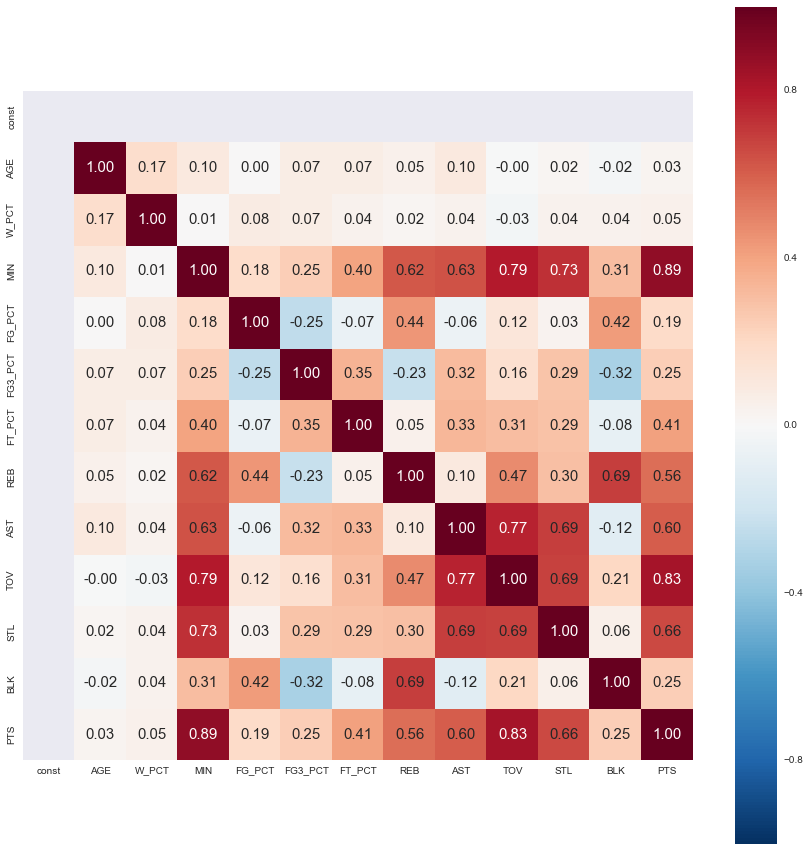

In [39]:
plt.figure(figsize=(15, 15))
sns.heatmap(np.corrcoef(dfX.T), annot=True, square=True, fmt='.2f', annot_kws={'size':15},
            yticklabels=dfX.columns, xticklabels=dfX.columns)

### Collinearity Review

* MIN과 PTS는 강한 상관관계를 보인다. 왜냐하면 뛴 시간만큼 득점력이 높아지기 때문이다.
 * MIN은 PTS 밖에도 STL, AST, REB 와도 관련이 있다. 뛴 시간만큼 많아지기 때문이다.
 * MIN => PTS, STL, AST, REB, TOV
--- 
* REB와 BLK 높은 이유는 리바운드는 주로 센터와 포워드들이 잡는다. 그리고 블락도 대부분 이 포지션들이 한다. 포지션의 특성이다.
 * OREB와 DREB도 같은 이유로 높다. 그런 이유로 REB만 남겼다.
 * REB - BLK
---
* AST와 STL, TOV 가 높은 이유는 STL, TOV 또한 가드들의 포지션 특성이기 때문이다.
 * AST - STL - TOV

* 어떤 X값들로만 만들어 갈 것인지 하나씩 살펴보고 다시 전처리 과정부터 시작해보자

In [54]:
df_all_test1 = df_all.drop(['MIN', 'STL', 'TOV', 'BLK',
       ], axis=1)

In [55]:
# OLS 그려주는 함수 만들기
def OLS_result(y, x) : 
    model_OLS = sm.OLS(y, x) 
    result_OLS = model_OLS.fit()
    return result_OLS

In [56]:
print(OLS_result(df_all_test1.ix[:, -1], df_all_test1.ix[:, :-1]).summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     464.4
Date:                Wed, 03 Aug 2016   Prob (F-statistic):               0.00
Time:                        15:27:39   Log-Likelihood:                -44516.
No. Observations:                2711   AIC:                         8.905e+04
Df Residuals:                    2702   BIC:                         8.910e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -6.125e+06   6.51e+05     -9.406      0.0

In [57]:
df_all_test2 = df_all_test1.drop(['FG_PCT'], axis=1)

In [58]:
print(OLS_result(df_all_test2.ix[:, -1], df_all_test2.ix[:, :-1]).summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     530.0
Date:                Wed, 03 Aug 2016   Prob (F-statistic):               0.00
Time:                        15:27:52   Log-Likelihood:                -44518.
No. Observations:                2711   AIC:                         8.905e+04
Df Residuals:                    2703   BIC:                         8.910e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -6.809e+06   5.09e+05    -13.375      0.0

In [75]:
df_all_test3 = df_all_test2.drop(['FT_PCT'], axis=1)

In [76]:
print(OLS_result(df_all_test3.ix[:, -1], df_all_test3.ix[:, :-1]).summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     605.2
Date:                Wed, 03 Aug 2016   Prob (F-statistic):               0.00
Time:                        15:31:32   Log-Likelihood:                -44535.
No. Observations:                2711   AIC:                         8.908e+04
Df Residuals:                    2704   BIC:                         8.913e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -8.278e+06   4.46e+05    -18.558      0.0

* 여러차례 test 해 본 결과 feature 값으로 최종 결정한 것은 AGE, W_PCT, FG3_PCT, REB, AST, PTS이다.
* 나이, 승률, 게임 시간, 리바운드, 어시스트, 경기당 득점

In [79]:
df_all_3 = df_all_test3

In [80]:
df_all_3.head()

,const,AGE,W_PCT,FG3_PCT,REB,AST,PTS,Salary
0,1,5.563225,4.119050,1.899278,0.426470,0.878832,0.879138,1045560
1,1,5.563225,2.199550,0.000000,1.085560,0.361872,0.726980,711517
2,1,5.563225,2.602120,1.185610,0.387700,1.033921,0.710073,2071680
3,1,6.772622,3.459769,2.158270,2.093581,0.827136,2.299284,9226250
4,1,5.321346,2.666298,0.000000,3.760691,0.775440,1.707557,4023720


In [81]:
df_all_3.columns

Index(['const', 'AGE', 'W_PCT', 'FG3_PCT', 'REB', 'AST', 'PTS', 'Salary'], dtype='object')

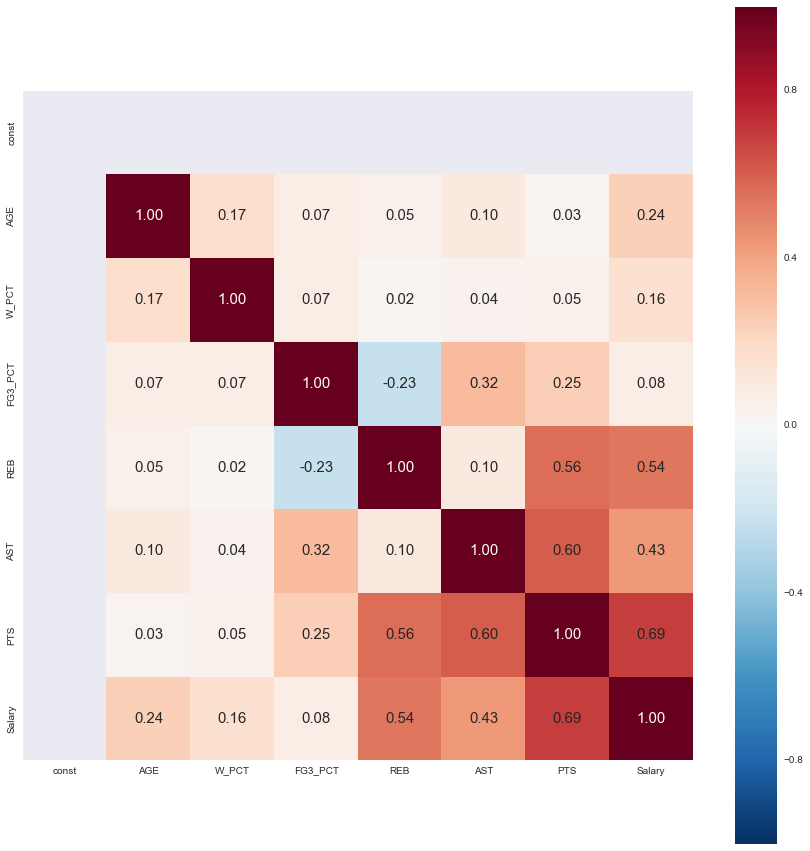

In [82]:
#다시 다중공선성 확인. 0.7미만이면 안전합니다.
plt.figure(figsize=(15, 15))
sns.heatmap(np.corrcoef(df_all_3.T), annot=True, square=True, fmt='.2f', annot_kws={'size':15},
            yticklabels=df_all_3.columns, xticklabels=df_all_3.columns)

In [83]:
model333 = sm.OLS.from_formula("Salary ~ PTS + REB + AST + W_PCT + AGE + FG3_PCT", data=df_all_3)
result = model333.fit()     #모형 계수 추정, 트레이닝(training)
table = sm.stats.anova_lm(result)
table.sort_values("F", ascending=False)

,df,sum_sq,mean_sq,F,PR(>F)
PTS,1.0,3.333862e+16,3.333862e+16,3058.735227,0.000000e+00
REB,1.0,2.282335e+15,2.282335e+15,209.398489,9.119069e-46
AGE,1.0,2.261601e+15,2.261601e+15,207.496237,2.214505e-45
W_PCT,1.0,1.048975e+15,1.048975e+15,96.240851,2.389432e-22
AST,1.0,5.041936e+14,5.041936e+14,46.258502,1.270905e-11
FG3_PCT,1.0,1.395391e+14,1.395391e+14,12.802365,3.522619e-04
Residual,2704.0,2.947219e+16,1.089948e+13,NaN,NaN


In [84]:
#predict할 test set 만들기
test_predict_2015_df_3 = player_salary_2015_df.drop(['Unnamed: 0', 'PLAYER_ID', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'GP', 'W', 'L', 'FGM',
       'FGA', 'FG3A', 'FG3M', 'FTM', 'FTA',
       'TOV', 'BLKA', 'PF', 'PFD', 'FT_PCT', 'FG_PCT', 'MIN',
       'PLUS_MINUS', 'DD2', 'TD3', 'CFID', 'CFPARAMS', 'OREB', 'DREB', 'STL', 'BLK'], axis=1)
test_predict_2015_df_3.head()

,PLAYER_NAME,AGE,W_PCT,FG3_PCT,REB,AST,PTS,Salary
0,Aaron Gordon,20.0,0.410,0.296,6.5,1.6,9.2,4351320
1,Aaron Harrison,21.0,0.714,0.300,0.7,0.1,0.9,874636
2,Adreian Payne,25.0,0.346,0.281,2.1,0.6,2.5,2022240
3,Al Horford,30.0,0.585,0.344,7.3,3.2,15.2,26540100
4,Al Jefferson,31.0,0.702,0.000,6.4,1.5,12.0,10314532


In [85]:
#상수항 추가한 pred을 구하기 위한 test값
train_3 = test_predict_2015_df_3.ix[:, 1:-1]
scaler = StandardScaler(with_mean=False)
X_scaled_3 = scaler.fit_transform(train_3)
dfy_test = test_predict_2015_df_3["Salary"]

dfX0_3 = pd.DataFrame(X_scaled_3, columns=train_3.columns)
dfX_33 = sm.add_constant(dfX0_3)
test_predict_2015_df_33 = pd.concat([dfX_33, dfy_test], axis=1)
test_predict_2015_df_3 = pd.concat([test_predict_2015_df_3["PLAYER_NAME"], test_predict_2015_df_33], axis=1)
test_predict_2015_df_3.head()

,PLAYER_NAME,const,AGE,W_PCT,FG3_PCT,REB,AST,PTS,Salary
0,Aaron Gordon,1,4.650360,2.270248,1.998684,2.781462,0.865926,1.689939,4351320
1,Aaron Harrison,1,4.882878,3.953554,2.025693,0.299542,0.054120,0.165320,874636
2,Adreian Payne,1,5.812950,1.915868,1.897399,0.898626,0.324722,0.459223,2022240
3,Al Horford,1,6.975540,3.239256,2.322795,3.123795,1.731851,2.792074,26540100
4,Al Jefferson,1,7.208058,3.887107,0.000000,2.738670,0.811805,2.204269,10314532


In [86]:
# 추정값 확인
model3_OLS = sm.OLS(dfy, dfX[['const', 'AGE', 'W_PCT', 'FG3_PCT', 'REB', 'AST', 'PTS']])
result3_OLS = model3_OLS.fit()
prediction3 = result3_OLS.predict(test_predict_2015_df_3.ix[:, 1:-1])
pred_y = pd.DataFrame(prediction3, columns=["Salary_pred"])
third_result = pd.concat([test_predict_2015_df_3["PLAYER_NAME"], pred_y], axis=1)
third_result.head()

,PLAYER_NAME,Salary_pred
0,Aaron Gordon,4.563144e+06
1,Aaron Harrison,-1.495601e+06
2,Adreian Payne,-3.556032e+03
3,Al Horford,1.082914e+07
4,Al Jefferson,9.595413e+06


In [89]:
#10명 중 2명 맞았고
result_10 = test_result_2016_df.sort_values("Salary", ascending=False).head(10)["PLAYER_NAME"]   
predict_10 = third_result.sort_values("Salary_pred", ascending=False).head(10)["PLAYER_NAME"]
tmp1 = result_10.sort_values("index")
tmp2 = predict_10.sort_values("index")

for i in range(len(tmp1)):
    for j in range(len(tmp2)):
        if tmp1.values[i] == tmp2.values[j]:
            print(tmp1.values[i])

Carmelo Anthony
Damian Lillard


In [90]:
#30명 중 18명 맞았음
result_30 = test_result_2016_df.sort_values("Salary", ascending=False).head(30)["PLAYER_NAME"]   
predict_30 = third_result.sort_values("Salary_pred", ascending=False).head(30)["PLAYER_NAME"]
tmp1 = result_30.sort_values("index")
tmp2 = predict_30.sort_values("index")

for i in range(len(tmp1)):
    for j in range(len(tmp2)):
        if tmp1.values[i] == tmp2.values[j]:
            print(tmp1.values[i])

Anthony Davis
Blake Griffin
Brook Lopez
Carmelo Anthony
Chris Bosh
Chris Paul
Damian Lillard
Dirk Nowitzki
Dwight Howard
Dwyane Wade
Jimmy Butler
Kawhi Leonard
Kevin Love
LaMarcus Aldridge
Marc Gasol
Paul George
Paul Millsap
Russell Westbrook


In [58]:
#50명 중 31명 맞았음
result_50 = test_result_2016_df.sort_values("Salary", ascending=False).head(50)["PLAYER_NAME"]   
predict_50 = third_result.sort_values("Salary_pred", ascending=False).head(50)["PLAYER_NAME"]
tmp1 = result_50.sort_values("index")
tmp2 = predict_50.sort_values("index")

for i in range(len(tmp1)):
    for j in range(len(tmp2)):
        if tmp1.values[i] == tmp2.values[j]:
            print(tmp1.values[i])

Al Horford
Anthony Davis
Blake Griffin
Brook Lopez
Carmelo Anthony
Chris Bosh
Chris Paul
Damian Lillard
Danilo Gallinari
DeMarcus Cousins
Dirk Nowitzki
Draymond Green
Dwight Howard
Dwyane Wade
Goran Dragic
Gordon Hayward
Jimmy Butler
John Wall
Kawhi Leonard
Kevin Love
Klay Thompson
Kyrie Irving
LaMarcus Aldridge
Marc Gasol
Nicolas Batum
Pau Gasol
Paul George
Paul Millsap
Russell Westbrook
Ryan Anderson


CV 한 번 해보자

In [94]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(df_all.ix[:, :-1], df_all.ix[:, -1])
model.intercept_, model.coef_

(-5721839.8735088604,
 array([       0.        ,  1031165.33896045,   439911.25230114,
         -925426.01765246,  -185303.36525157,   -33637.5597669 ,
         -369356.66020239,  1099265.21761465,   682066.85046601,
          245118.00879977,  -230256.51514067,   397894.26933185,
         3300873.63322432]))

In [95]:
from sklearn.cross_validation import cross_val_score

In [96]:
score = cross_val_score(model, df_all.ix[:, :-1], df_all.ix[:, -1], cv=5)   #`score()`: 성과 분석
score, score.mean(), score.std()

(array([ 0.59623424,  0.57401611,  0.61617226,  0.60052476,  0.52084008]),
 0.58155748889287595,
 0.033216933126784878)

In [99]:
model3 = LinearRegression()
model3.fit(df_all_3.ix[:, :-1], df_all_3.ix[:, -1])
model.intercept_, model.coef_

(-5721839.8735088604,
 array([       0.        ,  1031165.33896045,   439911.25230114,
         -925426.01765246,  -185303.36525157,   -33637.5597669 ,
         -369356.66020239,  1099265.21761465,   682066.85046601,
          245118.00879977,  -230256.51514067,   397894.26933185,
         3300873.63322432]))

In [ ]:
score2 = cross_val_score2(model, df_all_2.ix[:, :-1], df_all_2.ix[:, -1], cv=5)   #`score()`: 성과 분석
score, score.mean(), score.std()

## RidgeCV / LassoCV / ElasticNetCV

### 복수의 alpha 값에 대해 자동으로 fit 및 최적값을 찾음

In [59]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

In [60]:
alphas = np.logspace(-4, -0.01)
ridge_cv = RidgeCV(alphas=alphas)
ridge_cv.fit(dfX[['const', 'AGE', 'W_PCT', 'FG3_PCT', 'REB', 'AST', 'PTS']], dfy)
lasso_cv = LassoCV(alphas=alphas)
lasso_cv.fit(dfX[['const', 'AGE', 'W_PCT', 'FG3_PCT', 'REB', 'AST', 'PTS']], dfy)
elastic_cv = ElasticNetCV(alphas=alphas)
elastic_cv.fit(dfX[['const', 'AGE', 'W_PCT', 'FG3_PCT', 'REB', 'AST', 'PTS']], dfy)

print("alphas : ", alphas)
print("\n")
print("ridge_cv : ", ridge_cv.alpha_ )
print("lasso_cv : ", lasso_cv.alpha_ )
print("elastic_cv : ", elastic_cv.alpha_ )

alphas :  [  1.00000000e-04   1.20622568e-04   1.45498040e-04   1.75503473e-04
   2.11696796e-04   2.55354113e-04   3.08014689e-04   3.71535229e-04
   4.48155336e-04   5.40576476e-04   6.52057229e-04   7.86528177e-04
   9.48730488e-04   1.14438308e-03   1.38038426e-03   1.66505495e-03
   2.00843205e-03   2.42262232e-03   2.92222926e-03   3.52486799e-03
   4.25178630e-03   5.12861384e-03   6.18626573e-03   7.46203261e-03
   9.00089539e-03   1.08571112e-02   1.30961264e-02   1.57968840e-02
   1.90546072e-02   2.29841566e-02   2.77240800e-02   3.34414973e-02
   4.03379929e-02   4.86567231e-02   5.86909891e-02   7.07945784e-02
   8.53942388e-02   1.03004724e-01   1.24246944e-01   1.49869855e-01
   1.80776868e-01   2.18057701e-01   2.63026799e-01   3.17269681e-01
   3.82698837e-01   4.61621167e-01   5.56819307e-01   6.71649750e-01
   8.10161178e-01   9.77237221e-01]


ridge_cv :  0.977237220956
lasso_cv :  0.977237220956
elastic_cv :  0.0229841565692


In [61]:
# OLS fit_regularized 그려주는 함수 만들기
def OLS_regularized(y, x, alpha) : 
    model_OLS = sm.OLS(y, x) 
    result_OLS = model_OLS.fit_regularized(alpha=alpha)
    return result_OLS

In [62]:
print(OLS_regularized(dfy, dfX[['const', 'AGE', 'W_PCT', 'FG3_PCT', 'REB', 'AST', 'PTS']], lasso_cv.alpha_).summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     461.7
Date:                Tue, 02 Aug 2016   Prob (F-statistic):               0.00
Time:                        14:11:35   Log-Likelihood:                -33836.
No. Observations:                2062   AIC:                         6.769e+04
Df Residuals:                    2055   BIC:                         6.773e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -8.512e+06   4.98e+05    -17.076      0.0

In [63]:
print(OLS_result(df_all_test3.ix[:, -1], df_all_test3.ix[:, :-1]).summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     461.7
Date:                Tue, 02 Aug 2016   Prob (F-statistic):               0.00
Time:                        14:11:35   Log-Likelihood:                -33836.
No. Observations:                2062   AIC:                         6.769e+04
Df Residuals:                    2055   BIC:                         6.773e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -8.512e+06   4.98e+05    -17.076      0.0

해도 결과는 달라지지 않아 의미가 없는데...

## 결과 정리
* 결과는? PTS(경기당 득점률)로만 연봉이 정해지지 않는다.

* 데이터 측면에서만 봤을 때 연봉에 영향을 주는 X값으로는 1번째, 3번째 모델이다. 하지만 최소 feature로 사용 된 3번째 모델로
    * AGE: 선수들 나이
    * W_PCT: 승률
    * FG3_PCT: 3점슛 성공률
    * AST: assists
    * REB: rebound
    * PTS: 평균 득점력(모든 득점력/뛴 모든 경기수)

* 연봉을 정확히 예측하기 어려운 이유?
 * 스테판 커리의 경우 결과 데이터로는 1위. 하지만 부상이 잦은 이유로 계약 당시 낮게 책정
 * 계약 당시의 선수들의 컨디션 또한 좌우 된다.
 * 그 밖에도 4쿼터에서의 활약, 스크린이나 박스 아웃 등의 기록되지 않는 공헌도 등의 영향으로 인해
 * 연봉을 정확히 예측하는 것은 어렵다.
 
* 활용가치? 적게 받지만 기록이 좋은 선수들이 있다.
 * 종합적인 결과 데이터를 바탕으로 저평가 되어 있는 선수들을 한 눈에 볼 수 있다.
 * 저평가라는 것은 결과 데이터에 비해 낮은 연봉을 받는 선수들